# Tutorial 3 - Initialization Types

Having worked with different layer types, for this tutorial we will stick to Chebyshev-based KANs in order to explore different initialization strategies. Once again, we will be re-using the code shown in the previous notebooks for the definition, training and evaluation of the models.

In [1]:
from jaxkan.models.KAN import KAN

import jax
import jax.numpy as jnp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## Experiment Setup

In [2]:
def f(x,y):
    return x**2 + 2*jnp.exp(y)

def generate_data(minval=-1, maxval=1, num_samples=1000, seed=42):
    key = jax.random.PRNGKey(seed)
    x_key, y_key = jax.random.split(key)

    x1 = jax.random.uniform(x_key, shape=(num_samples,), minval=minval, maxval=maxval)
    x2 = jax.random.uniform(y_key, shape=(num_samples,), minval=minval, maxval=maxval)

    y = f(x1, x2).reshape(-1, 1)
    X = jnp.stack([x1, x2], axis=1)
    
    return X, y

seed = 42

X, y = generate_data(minval=-1, maxval=1, num_samples=1000, seed=seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Define the static parameters
n_in = X_train.shape[1]
n_out = y_train.shape[1]
n_hidden = 6

layer_dims = [n_in, n_hidden, n_hidden, n_out]

Training set size: (800, 2)
Test set size: (200, 2)


As in the previous notebook, we define a function that incorporates everything. Here, we set `init_scheme` as its only input, in order to investigate different initialization strategies.

In [3]:
def run_experiment(init_scheme):

    layer_type = "chebyshev"

    required_parameters = {'D': 5, 'flavor': 'exact',
                           'residual': None, 'external_weights': False,
                           'init_scheme': init_scheme,
                           'add_bias': True}

    # Initialize a KAN model, depending on the inputs of the experiment
    model = KAN(layer_dims = layer_dims,
                layer_type = layer_type,
                required_parameters = required_parameters,
                seed = 42
               )

    # Define Optimizer
    opt_type = optax.adam(learning_rate=0.001)
    optimizer = nnx.Optimizer(model, opt_type, wrt=nnx.Param)

    # Define train loop
    @nnx.jit
    def train_step(model, optimizer, X_train, y_train):
    
        def loss_fn(model):
            residual = model(X_train) - y_train
            loss = jnp.mean((residual)**2)
    
            return loss
        
        loss, grads = nnx.value_and_grad(loss_fn)(model)
        optimizer.update(model, grads)
        
        return loss

    # Do training
    num_epochs = 2000
    train_losses = jnp.zeros((num_epochs,))
    
    for epoch in range(num_epochs):
        # Calculate the loss
        loss = train_step(model, optimizer, X_train, y_train)
        
        # Append the loss
        train_losses = train_losses.at[epoch].set(loss)

    # Get MSE on test set
    y_pred = model(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"The MSE of the fit is {mse:.5f}\n\n")

    # Plot Losses
    plt.figure(figsize=(7, 4))

    plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.yscale('log')
    
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5) 
    
    plt.show()

    return

## Experiments

We will then run this function with different initialization techniques.

### Default Initialization

The `default` initialization corresponds to the first initialization type introduced for each KAN layer in the paper that proposed it.

The MSE of the fit is 0.00563




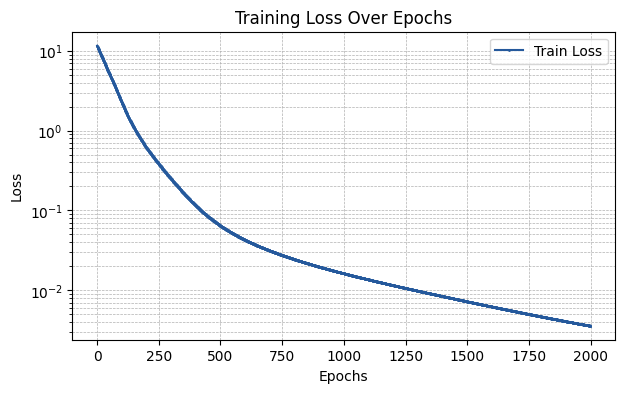

In [4]:
init_scheme = {"type": "default"}

run_experiment(init_scheme)

### LeCun Initialization

The `lecun` initialization corresponds to the LeCun-inspired initialization introduced in [Initialization Schemes for Kolmogorov–Arnold Networks: An Empirical Study](https://openreview.net/forum?id=dwNXKkiP51). See the paper for more details.

Note that this initialization includes additional parameters for the `init_scheme` dictionary.

- `distribution`: Corresponds to the distribution used to create a sample from which to draw all expectation values involved in the initialization process.
- `sample_size`: Defines the size of the aforementioned sample.
- `gain`: Introduces a multiplicative factor for the standard distribution of the initialized weights.

The MSE of the fit is 0.00630




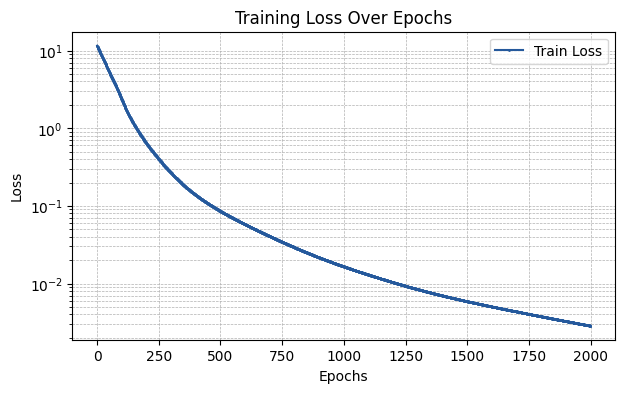

In [5]:
init_scheme = {"type": "lecun", "distribution": "uniform", "sample_size": 10000, "gain": None}

run_experiment(init_scheme)

### Glorot Initialization

The `glorot` initialization corresponds to the Glorot-inspired initialization introduced in [Initialization Schemes for Kolmogorov–Arnold Networks: An Empirical Study](https://openreview.net/forum?id=dwNXKkiP51). See the paper for more details.

The MSE of the fit is 0.00090




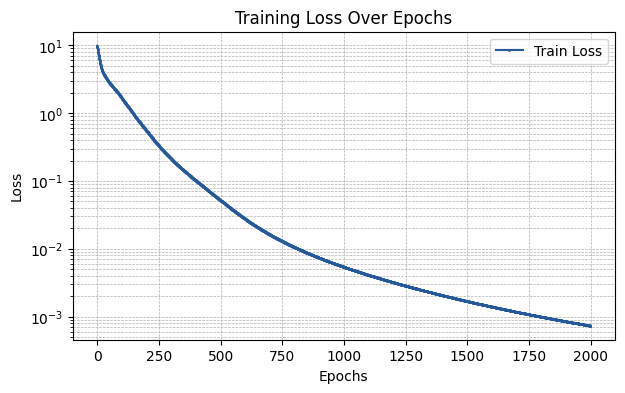

In [6]:
init_scheme = {"type": "glorot", "distribution": "uniform", "sample_size": 10000, "gain": None}

run_experiment(init_scheme)

### Fine Glorot Initialization

The `glorot_fine` initialization corresponds to the Glorot-inspired initialization introduced in [Towards Deep Physics-Informed Kolmogorov-Arnold Networks](https://www.arxiv.org/abs/2510.23501). Essentially, it's a basis-function-term-dependent initialization, which introduces a different standard deviation per basis function term. See the paper for more details.

The MSE of the fit is 0.00090




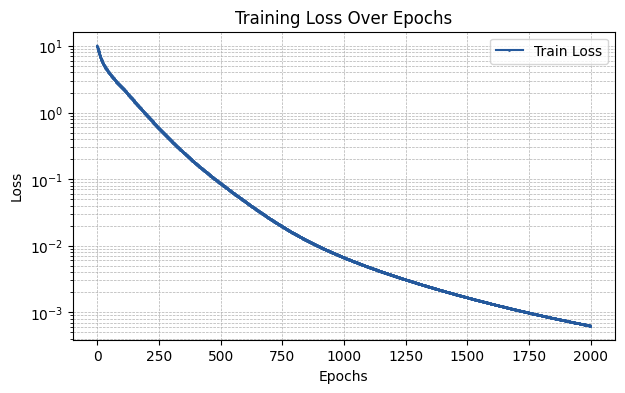

In [7]:
init_scheme = {"type": "glorot_fine", "distribution": "uniform", "sample_size": 10000, "gain": None}

run_experiment(init_scheme)

### Power-Law Initialization

The `power` initialization corresponds to a generalization of the power-law initialization introduced in [Initialization Schemes for Kolmogorov–Arnold Networks: An Empirical Study](https://openreview.net/forum?id=dwNXKkiP51).

In its more general form, this initialization initializes residual and basis weights following $\mathcal{N}\left(0, \sigma_r^2\right)$ and $\mathcal{N}\left(0, \sigma_b^2\right)$, respectively, where

$$ \sigma_r = c_r \times \frac{1}{n_\text{in}^{\alpha_1} \times \left(D+1\right)^{\alpha_2}} \qquad \sigma_b = c_b \times \frac{1}{n_\text{in}^{\beta_1} \times \left(D+1\right)^{\beta_2}}, $$

with $D$ being equal to $G+k$ for spline-based KAN layers.

See the paper for more details, where $c_r = c_b = 1.0$, $\alpha_1 = \alpha_2 = \alpha$ and $\beta_1 = \beta_2 = \beta$.

The MSE of the fit is 0.00127




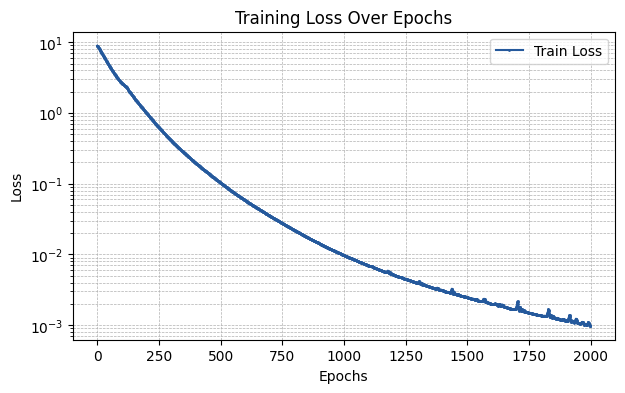

In [8]:
init_scheme = {"type": "power", "const_b": 1.0, "const_r": 1.0, "pow_b1": 1.75, "pow_b2": 1.75, "pow_r1": 0.25, "pow_r2": 0.25}

run_experiment(init_scheme)